In [1]:
import numpy as np
import networkx  as nx
import time 
import matplotlib.pyplot as plt
import multiprocessing
from joblib import Parallel, delayed
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.axes as ax

In [3]:
class IsingModel():
    
    def __init__(self, graph):
        
        self.name = "IsingModel"
        self.size = graph.number_of_nodes()
        self.graph = graph
        self.list_of_neigh = {}
        for node in self.graph.nodes():
            self.list_of_neigh[node] = list(self.graph.neighbors(node))
        
    def initialize(self, initial_state):
        
        self.state = np.full(self.size, initial_state)

    def set_J(self, J):
        """Set the value of J

        Parameter(s)
        ----------
        J : int
            This is the interaction coefficient.
        """
        self.J = J

    def set_iterations(self, iterations):
        """Set your desired number of iterations per temperature value

        Parameter(s)
        ----------
        iterations: int
            This is the number of iterations per temperature value.
        """
        self.iterations = iterations

    def set_burnin(self, burnin):
        self.burnin = burnin

    def set_initial_state(self, initial_state):
        """Set initial state

        Parameter(s):
        initial_state: int [0,1]
            This is the initial state of all nodes of the system.
        """
        if np.abs(initial_state)  !=1:
            raise Exception("initial_state should be all -1 or 1")
        
        self.initial_state = initial_state
    
    def __netmag(self):
        '''Calculate the net magnetization
        
        '''  
        return np.sum(self.state)
    
    def __netenergy(self):
        '''Calculate the net energy
        
        '''
        en = 0.
        for i in range(self.size):
            ss = np.sum(self.state[self.list_of_neigh[i]])
            en += self.state[i] * ss

        return -0.5 * self.J * en
    
    def __montecarlo(self):
        # pick a random source node which means q(theta'|theta) is random even distribution
        beta = 1/self.temperature
        rsnode = np.random.randint(0, self.size)
        # get the spin of this node
        s = self.state[rsnode]
        # sum of all neighbouring spins
        ss = np.sum(self.state[self.list_of_neigh[rsnode]])
        # transition energy
        delE = 2.0 * self.J * ss * s
        # calculate transition probability
        accept_prob = np.exp(-delE * beta)
        # conditionally accept the transition

        if accept_prob > np.random.uniform():
            s = -s
            self.state[rsnode] = s
            return [2*s, delE]
        else:
            return [0, 0]
        

    
    def simulate(self, temperature):
        
        self.temperature = temperature
        self.initialize(self.initial_state)
        # initialize spin vector

        for i in range(self.burnin):
            self.__montecarlo()
        # burn in
        mag = self.__netmag()
        ene = self.__netenergy()

        beta = 1/temperature
        n1 = 1/float(self.size) 
        E1 = E2 = M1 = M2 = 0
        m = e = c = x = 0
        DelE =0
        DelM =0

        delE_array = np.zeros(self.iterations)
        delM_array = np.zeros(self.iterations)
        for i in range(self.iterations):
            [dels, dele]=self.__montecarlo()
            DelM += dels
            DelE += dele
            delE_array[i] = DelE
            delM_array[i] = DelM

        E1 = np.mean(delE_array) + ene
        M1 = np.mean(delM_array) + mag
        M2 = np.mean(np.power(delM_array+mag ,2))
        E2 = np.mean(np.power(delE_array+ene ,2))
        m = M1*n1 
        e = E1*n1
        c = (E2 - np.power(E1,2))*beta** 2*n1
        x = (M2 - np.power(M1,2))*beta*n1

        return m, e, c, x


    def viz_parallel(self, temperature):
        """Simulate and visualise the energy and magnetization wrt a temperature range with python parallelization.
        
        Parameters
        ----------
        temperature: array_like
            This is the temperature range over which the model shall be simulated.

        """
        mag = []
        ene = []
        heca =[]
        magsus =[]
        num_cores = multiprocessing.cpu_count()
        results = Parallel(n_jobs=num_cores)(delayed(self.simulate)(i) for i in temperature)
    
        for cr in results:
            mag.append(cr[0])
            ene.append(cr[1])
            heca.append(cr[2])
            magsus.append(cr[3])

        return mag, ene, heca, magsus   

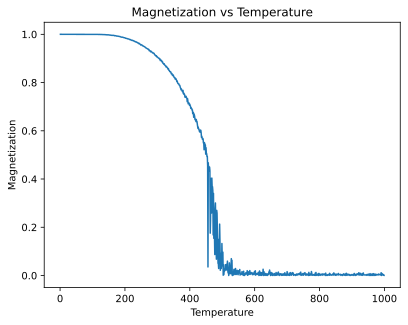

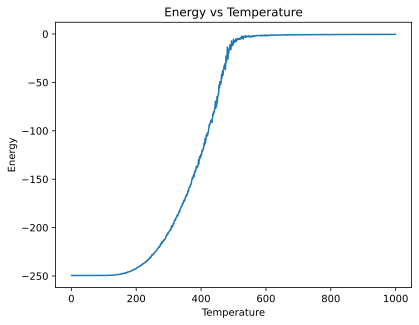

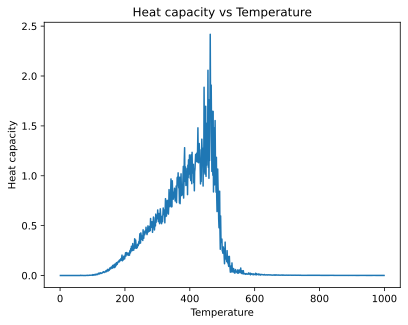

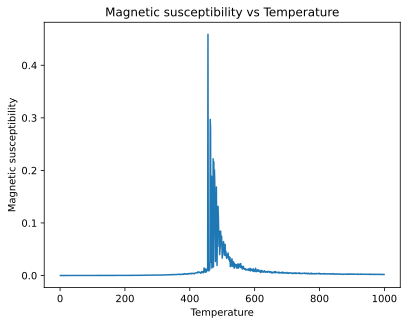

In [4]:
mage = []
ener = []
hecap =[]
magsusi =[]
g= nx.erdos_renyi_graph(1000,0.5)
model = IsingModel(g)
model.set_J(1.0)
model.set_iterations(300000)
model.set_initial_state(1) # 0 or 1
model.set_burnin(300000)
T = np.arange(1, 1000.0, 1)
[mage, ener, hecap, magsusi]  = model.viz_parallel(T)
np.savetxt('er_1000_0.5.txt', np.array([T, mage, ener, hecap, magsusi]))

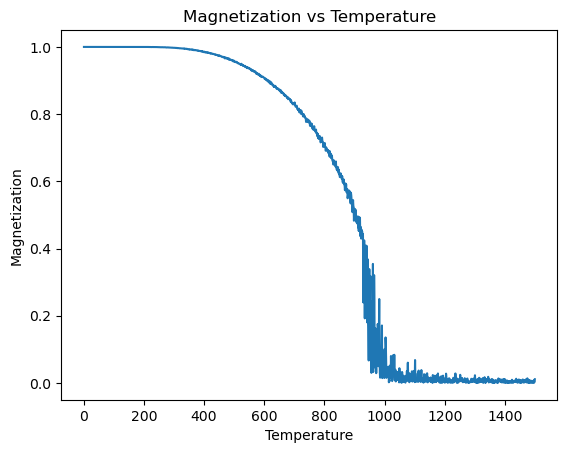

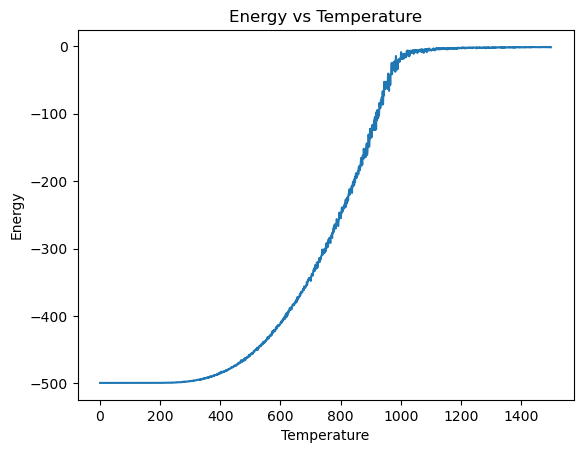

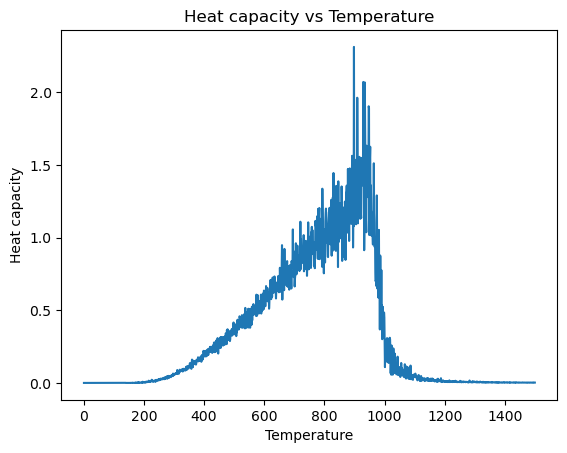

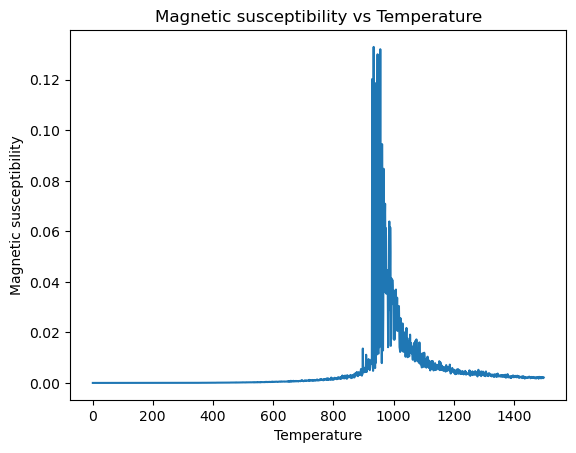

In [124]:
mage = []
ener = []
hecap =[]
magsusi =[]
g= nx.erdos_renyi_graph(1000,1)
model = IsingModel(g)
model.set_J(1.0)
model.set_iterations(300000)
model.set_initial_state(1) # 0 or 1
model.set_burnin(300000)
T = np.arange(1, 1500.0, 1)
[mage, ener, hecap, magsusi]  = model.viz_parallel(T)
np.savetxt('er_1000_1.txt', np.array([T, mage, ener, hecap, magsusi]))

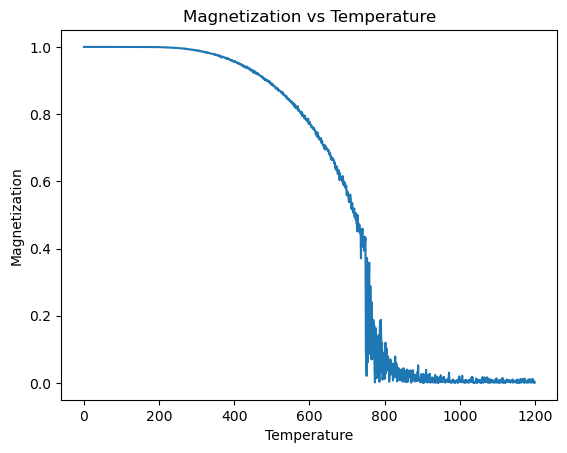

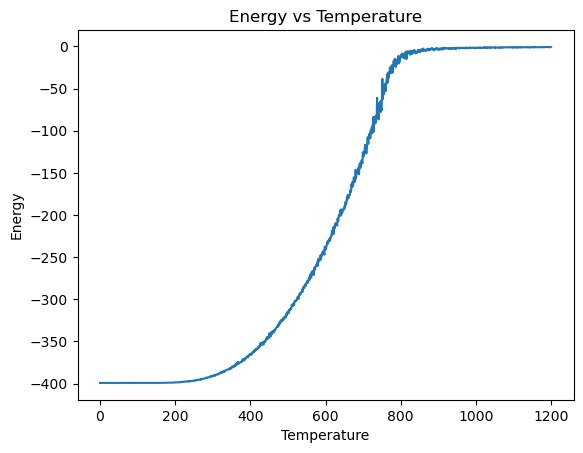

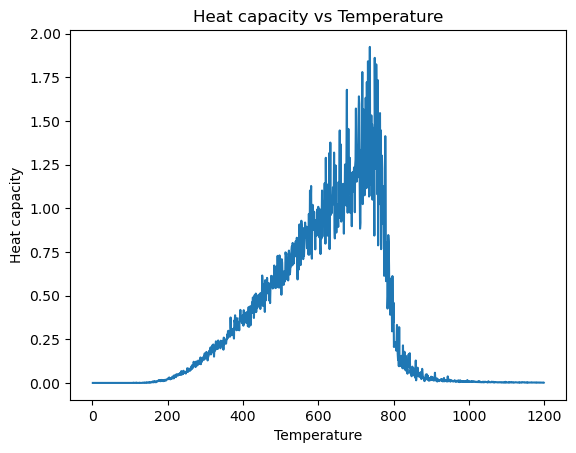

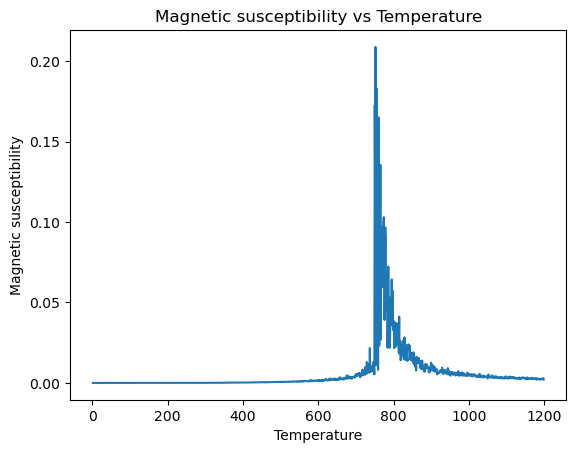

In [51]:
mage = []
ener = []
hecap =[]
magsusi =[]
g= nx.erdos_renyi_graph(1000,0.8)
model = IsingModel(g)
model.set_J(1.0)
model.set_iterations(300000)
model.set_initial_state(1) # 0 or 1
model.set_burnin(300000)
T = np.arange(1, 1200.0, 1)
[mage, ener, hecap, magsusi]  = model.viz_parallel(T)
np.savetxt('er_1000_0.8.txt', np.array([T, mage, ener, hecap, magsusi]))

In [71]:
KK = np.loadtxt('er_1000_0.8.txt')
KK_T = np.log(751.0-KK[0][740:750])
KK_m = np.log(np.abs(KK[1][740:750]))
k1 = np.polyfit(KK_T, KK_m, 1)
print(k1)

[ 0.49061799 -1.75907756]


<Figure size 640x480 with 0 Axes>

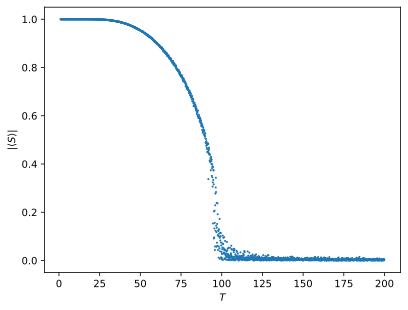

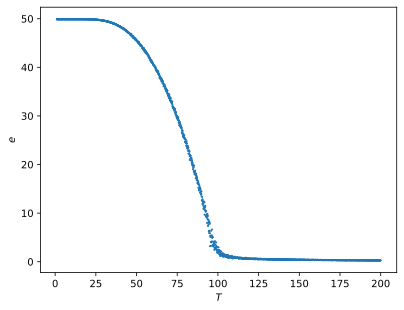

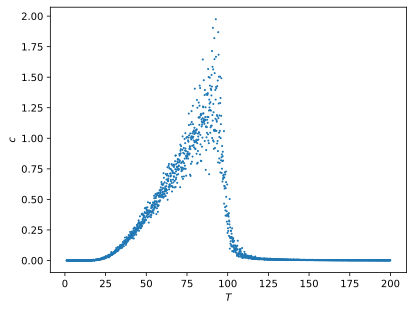

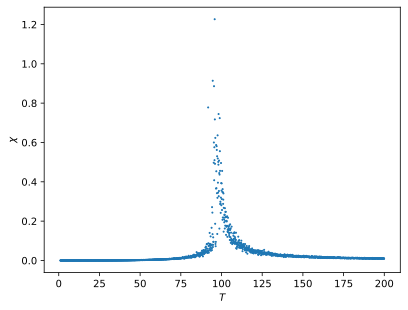

In [5]:
data01 = np.loadtxt('er_1000_0.1.txt')

plt.figure(1)

fig, ax = plt.subplots()
ax.scatter(data01[0], abs(data01[1]), s=5, marker='.')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$|\langle S \rangle |$')

fig.savefig("er_m1.pdf", dpi=600,format='pdf')

plt.figure(2)
fig, ax = plt.subplots()
ax.scatter(data01[0], abs(data01[2]), s=5, marker='.')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$e$')
fig.savefig('er_e1.pdf',dpi=600,format='pdf')

plt.figure(3)
fig, ax = plt.subplots()
ax.scatter(data01[0], data01[3], s=5, marker='.')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$c$')
fig.savefig('er_c1.pdf',dpi=600,format='pdf')

plt.figure(4)
fig, ax = plt.subplots()
ax.scatter(data01[0], data01[4], s=5, marker='.')
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$\chi$')
plt.savefig('er_chi1.pdf',dpi=600,format='pdf')

Text(0, 0.5, '$\\chi$')

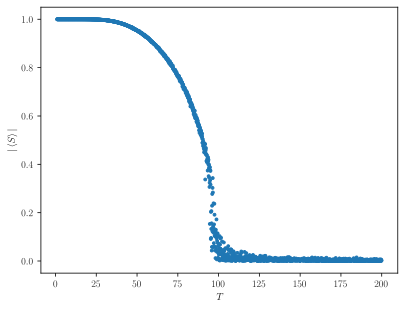

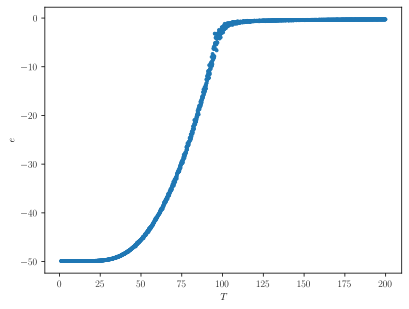

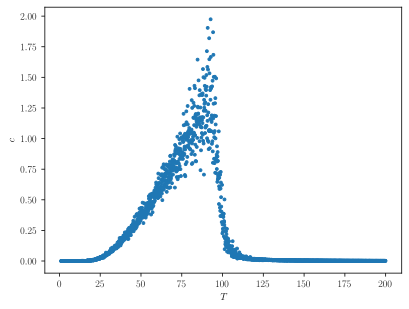

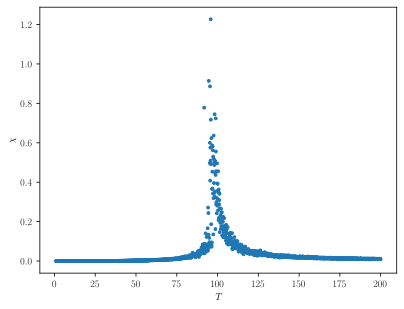

In [2]:
data01 = np.loadtxt('er_1000_0.1.txt')
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\n'.join([
    r'\usepackage{braket}',
])
plt.figure(1)
plt.scatter(data01[0], abs(data01[1]), s=8, marker='o')
plt.xlabel(r'$T$')
plt.ylabel(r'$|\braket{S}|$')
# plt.savefig('er_m.pdf',dpi=600,format='pdf')
plt.figure(2)
plt.scatter(data01[0], data01[2], s=8, marker='o')
plt.xlabel(r'$T$')
plt.ylabel(r'$e$')
plt.savefig('er_e.pdf',dpi=600,format='pdf')
plt.figure(3)
plt.scatter(data01[0], data01[3], s=8, marker='o')
plt.xlabel(r'$T$')
plt.ylabel(r'$c$')
# plt.savefig('er_c.pdf',dpi=600,format='pdf')
plt.figure(4)
plt.scatter(data01[0], data01[4], s=8, marker='o')
plt.xlabel(r'$T$')
plt.ylabel(r'$\chi$')
# plt.savefig('er_chi.pdf',dpi=600,format='pdf')

In [22]:
n = np.where(np.max(data01[4]) == data01[4])
print(n)
print(data01[0][n])

(array([948], dtype=int64),)
[95.8]


In [35]:
n = np.where(np.max(data01[3]) == data01[3])
print(n)
print(data01[0][n])

(array([917], dtype=int64),)
[92.7]


In [25]:
abs(data01[1][941:947])

array([0.31572562, 0.09127702, 0.20326387, 0.09548039, 0.13286587,
       0.20637286])

In [32]:
data01_T = np.log(95.8-data01[0][928:948])
data01_m = np.log(np.abs(data01[1][928:948]))
beta01 = np.polyfit(data01_T, data01_m, 1)
print(beta01)

[ 0.40820935 -1.27094418]


In [38]:
data01_T = np.log(92.7-data01[0][897:917])
data01_c = np.log(np.abs(data01[3][897:917]))
alpha01 = np.polyfit(data01_T, data01_c, 1)
print(alpha01)

[0.0260805  0.22713348]


In [40]:
data01_T = np.log(data01[0][918:938]-92.7)
data01_1_c = np.log(np.abs(data01[3][918:938]))
alpha01_1 = np.polyfit(data01_T, data01_1_c, 1)
print(alpha01_1)

[-0.05324331  0.2011083 ]


In [106]:
data01_T = np.log(95.8-data01[0][928:948])
data01_chi = np.log(np.abs(data01[4][928:948]))
chi01 = np.polyfit(data01_T, data01_chi, 1)
print(chi01)

[-0.74991971 -1.79706178]


Text(0, 0.5, '$\\chi$')

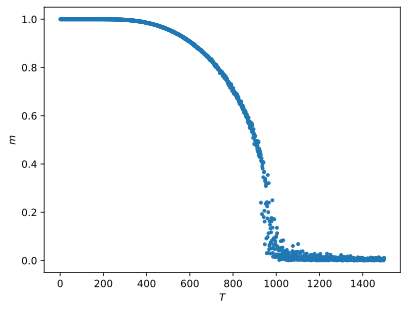

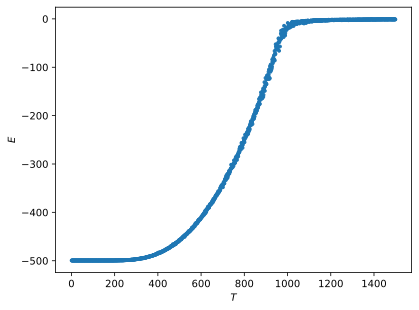

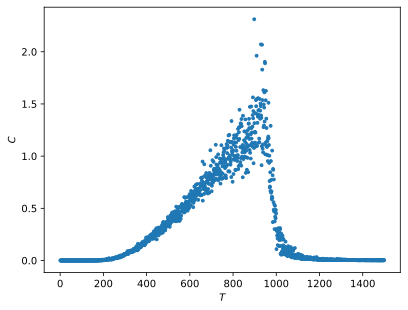

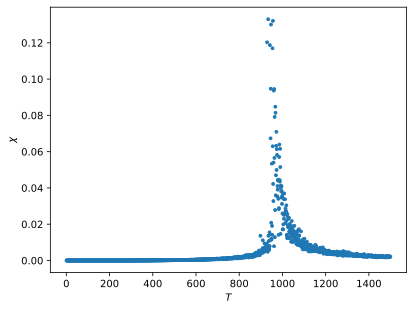

In [49]:
data1 = np.loadtxt('er_1000_1.txt')
plt.figure(1)
plt.scatter(data1[0], abs(data1[1]), s=8, marker='o')
plt.xlabel('$T$')
plt.ylabel('$m$')

plt.figure(2)
plt.scatter(data1[0], data1[2], s=8, marker='o')
plt.xlabel('$T$')
plt.ylabel('$E$')

plt.figure(3)
plt.scatter(data1[0], data1[3], s=8, marker='o')
plt.xlabel('$T$')
plt.ylabel('$C$')

plt.figure(4)
plt.scatter(data1[0], data1[4], s=8, marker='o')
plt.xlabel('$T$')
plt.ylabel('$\chi$')

In [51]:
n = np.where(np.max(data1[4]) == data1[4])
print(n)
print(data1[0][n])

(array([933], dtype=int64),)
[934.]


In [53]:
n = np.where(np.max(data1[3]) == data1[3])
print(n)
print(data1[0][n])

(array([897], dtype=int64),)
[898.]


In [80]:
data1_T = np.log(1000-data1[0][949:999])
data1_m = np.log(np.abs(data1[1][949:999]))
beta1 = np.polyfit(data1_T, data1_m, 1)
print(beta1)

[ 0.48479397 -3.78797886]


In [82]:
data1_T = np.log(898-data1[0][847:897])
data1_c = np.log(np.abs(data1[3][847:897]))
alpha1 = np.polyfit(data1_T, data1_c, 1)
print(alpha1)

[-0.03993177  0.25854708]


In [98]:
data1_T = np.log(924-data1[0][923-100:923])
data1_chi = np.log(np.abs(data1[4][923-100:923]))
chi1 = np.polyfit(data1_T, data1_chi, 1)
print(chi1)

[-0.37532725 -4.32099953]


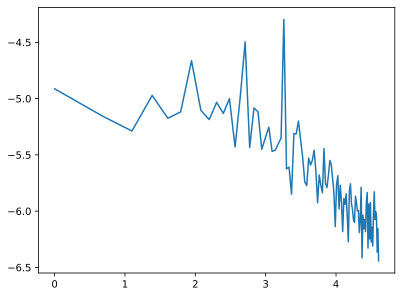

In [99]:
plt.plot(data1_T, data1_chi)

In [60]:
np.abs(data1[1][900:1000])

array([0.51495713, 0.49730053, 0.51580043, 0.49473916, 0.48128681,
       0.48479457, 0.47744705, 0.48520443, 0.47437765, 0.48360178,
       0.49563041, 0.46238092, 0.47619267, 0.45222807, 0.48882881,
       0.49360831, 0.45214892, 0.49078403, 0.4368757 , 0.44088273,
       0.46381401, 0.42951993, 0.45628959, 0.43434095, 0.45174746,
       0.43454384, 0.44417081, 0.43754496, 0.23962181, 0.41484589,
       0.41217228, 0.42426105, 0.41265586, 0.19221765, 0.38992345,
       0.40188716, 0.38108231, 0.40885747, 0.40447133, 0.34509596,
       0.40705532, 0.18008453, 0.36569437, 0.36786942, 0.20594221,
       0.16143423, 0.06687745, 0.32939023, 0.33869729, 0.33085923,
       0.23513527, 0.30857219, 0.31755538, 0.09118623, 0.23456137,
       0.02992886, 0.24179865, 0.22435097, 0.17436633, 0.09723716,
       0.35416722, 0.03253586, 0.20018111, 0.11283741, 0.32077786,
       0.23963684, 0.04643   , 0.06020619, 0.16326186, 0.06560073,
       0.14805223, 0.0290417 , 0.13281474, 0.07469631, 0.07367

## Numerical plot for BA network

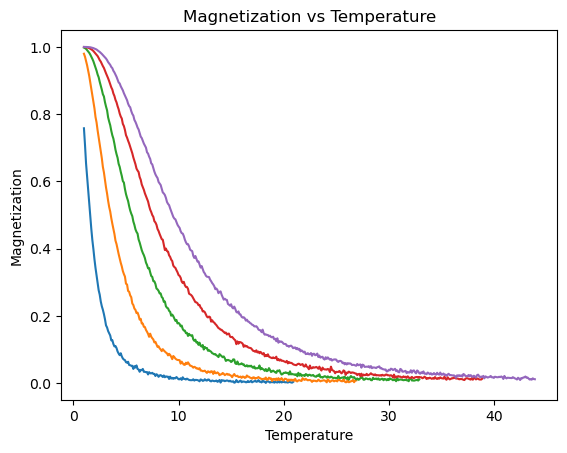

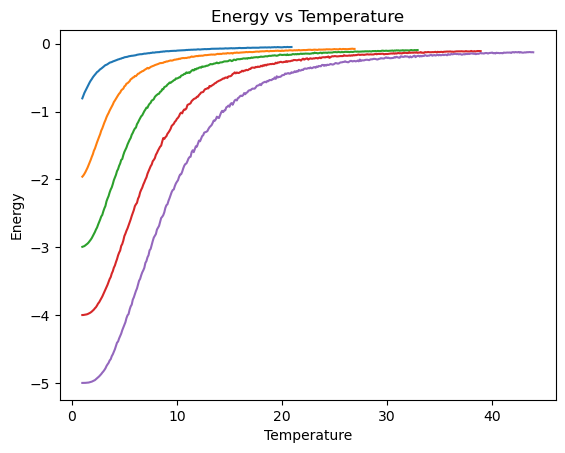

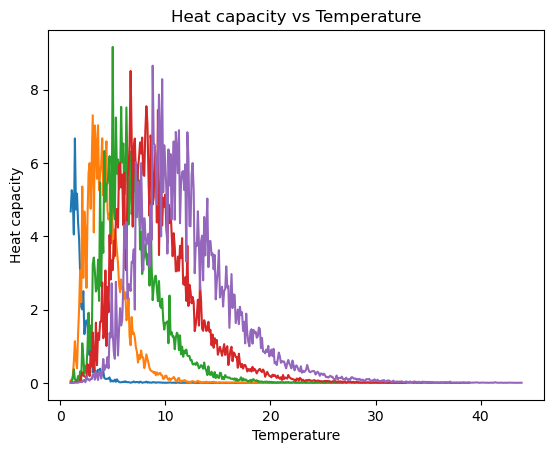

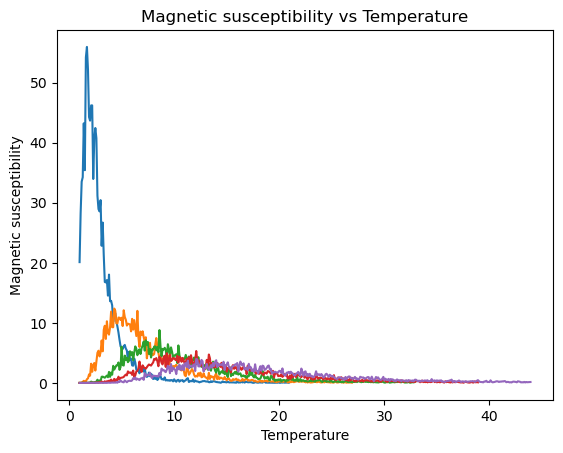

In [153]:
nodes = np.array([10,50,100,500, 1000, 2500, 5000, 10000]) 
for node_num in nodes:
    for mm in np.arange(1,5,1):
        mage = []
        ener = []
        hecap =[]
        magsusi =[]
        g= nx.barabasi_albert_graph(node_num,mm)
        model = IsingModel(g)
        model.set_J(1.0)
        model.set_iterations(300000)
        model.set_initial_state(1) # 0 or 1
        model.set_burnin(300000)

        Tc = mm/2.0*np.log(node_num)
        T = np.arange(1, np.ceil(Tc)+15.0, 0.1)
        [mage, ener, hecap, magsusi]  = model.viz_parallel(T)
        np.savetxt('ba_'+str(node_num)+'_'+str(mm)+'.txt', np.array([T, mage, ener, hecap, magsusi]))
    

In [6]:
nodes = np.array([10,50,100,500, 1000, 2500, 5000, 10000]) 
p=np.zeros([5,len(nodes)])
for mm in range(5):
    for j in range(len(nodes)):
        K = np.loadtxt('ba_'+str(nodes[j])+'_'+str(mm+1)+'.txt')
        p[mm][j] = K[0][np.where(abs(K[1]) < 0.005)[0][0]]

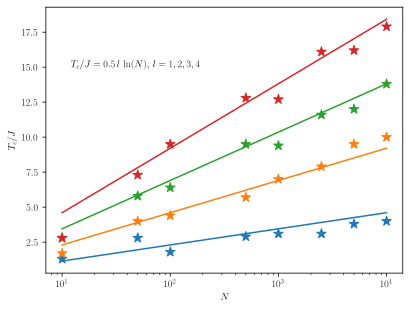

In [8]:
plt.rcParams['text.usetex'] = True
for i in range(4):
    plt.scatter(nodes, p[i], marker='*',s=100)
    y=plt.plot(nodes,(i+1)/2*np.log(nodes))
plt.xlabel(r'$N$')
plt.ylabel(r'$T_{c}/J$')
plt.xscale('log')
plt.text(12,15,r'$T_{c}/J=0.5 \, l \, \ln(N), \, l=1,2,3,4$')
# plt.show()
plt.savefig('ba_tc.pdf',dpi=600,format='pdf')

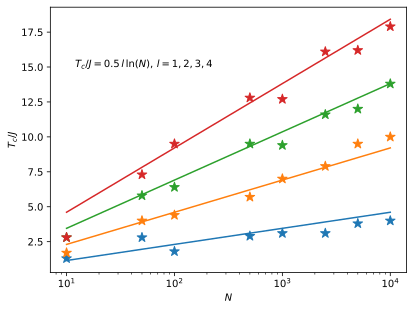

In [7]:
# plt.rcParams['text.usetex'] = True
for i in range(4):
    plt.scatter(nodes, p[i], marker='*',s=100)
    y=plt.plot(nodes,(i+1)/2*np.log(nodes))
plt.xlabel('$N$')
plt.ylabel('$T_{c}/J$')
plt.xscale('log')
plt.text(12,15,'$T_{c}/J=0.5 \, l \, \ln(N), \, l=1,2,3,4$')
# plt.show()
plt.savefig('ba_tc.pdf',dpi=600,format='pdf')